## Import Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from itertools import chain

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import transform_fns as trans
import pdm_functions as fns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import gaussian_kde

import pickle



## Weight계산 

In [2]:
df_normal= pd.read_csv('dataset/5528_spec_normal.csv')
df_error= pd.read_csv('dataset/5528_spec_error.csv')

In [3]:
df_normal['spectrum_x_amp']= df_normal['spectrum_x_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])

In [4]:
wf = fns.rpm_approx_weighted_fn(df_normal['spectrum_x_amp'], 1, 2048, 2048)

### <span style='color:red'> 가중치 standardization </span>

In [5]:
wf = fns.min_max_standardization(wf)

In [6]:
wf = wf * 36
wf = torch.tensor(wf)

## 데이터셋 (tensors)

In [7]:
df_normal = fns.csv_to_tensor_stack('dataset/5528_spec_normal.csv')
df_error = fns.csv_to_tensor_stack('dataset/5528_spec_error.csv')

## 데이터셋에 가중치 곱하기

In [8]:
df_normal.shape
wf.shape
df_normal = df_normal * wf
df_error = df_error * wf

## 데이터셋 숫자 늘리기
### <span style='color:red'> 몇 배로 데이터를 늘릴 것인가 multi_dim </span>

In [9]:
X_train, X_test, y_train, y_test= fns.binary_labeling(df_normal, df_error, test_size=.2, random_state=42 )

In [10]:
X_train.shape

torch.Size([156, 73728])

In [11]:
X_test.shape

torch.Size([39, 73728])

In [12]:
X_train_aug = fns.multi_datasets(X_train, multi_dim=200, num_groups=12)
y_train = y_train.repeat(200)

In [13]:
print(X_train_aug.shape, y_train.shape)

torch.Size([31200, 73728]) torch.Size([31200])


In [43]:
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))

2800
28400


### Dev_set augmented

In [14]:
file_path='dataset/train_datasets/dev_sets.pkl'
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Access the loaded data
X_dev_pickle = data['X_dev']
y_dev_pickle = data['y_dev']

print("Loaded X_dev:", X_dev_pickle)
print("Loaded y_dev:", y_dev_pickle)

C:\Users\user\anaconda3\envs\kdtproj\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Loaded X_dev: tensor([[2.1043e-04, 2.9448e-04, 2.4472e-04,  ..., 6.1457e-04, 6.1808e-04,
         5.6178e-04],
        [1.9647e-04, 2.4157e-04, 1.7535e-04,  ..., 1.1232e-04, 1.7699e-04,
         3.0490e-04],
        [2.6128e-04, 2.2513e-04, 1.0218e-04,  ..., 9.2347e-04, 7.9336e-04,
         4.3334e-04],
        ...,
        [4.0388e-04, 4.1982e-04, 2.7370e-04,  ..., 5.8726e-04, 7.4385e-04,
         7.6368e-04],
        [2.0376e-04, 3.0760e-04, 3.0270e-04,  ..., 9.7332e-04, 5.4711e-04,
         3.4396e-05],
        [7.4707e-05, 9.6044e-05, 2.9320e-04,  ..., 5.0607e-04, 6.4545e-04,
         5.9695e-04]])
Loaded y_dev: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8991, 0.9672,
        0.9818])


In [15]:
dev_x = fns.multi_datasets(X_dev_pickle, multi_dim = 10, num_groups= 12)
dev_y = y_dev_pickle.repeat(10)
dev_x.shape, dev_y.shape

In [17]:
# df_error_aug = fns.multi_datasets(df_error, multi_dim= 1100, num_groups=12)
#

## 데이터 상위 x개 추출
### <span style='color:red'> get_sorted_top_k_values(data, k = 5000)</span>

In [18]:
X_train = fns.get_sorted_top_k_values(X_train_aug, 5000)
test_x = fns.get_sorted_top_k_values(X_test, 5000)
X_dev_pickle = fns.get_sorted_top_k_values(dev_x, 5000)

In [19]:
X_train.shape, y_train.shape, X_dev_pickle.shape, y_dev_pickle.shape

(torch.Size([31200, 5000]),
 torch.Size([31200]),
 torch.Size([370, 5000]),
 torch.Size([37]))

### <span style="color:red"> Input값이 너무 작을 경우 곱셈으로 늘려준다 (예: * 1000)  </span>

In [20]:
train_x = X_train * 1000
test_x = test_x * 1000
dev_x = X_dev_pickle* 1000

<Axes: >

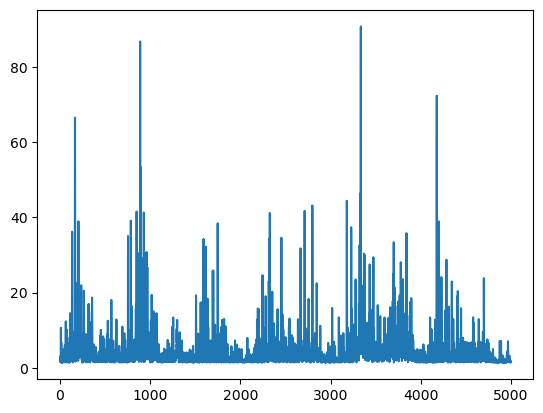

In [21]:
sns.lineplot(train_x[0])

<Axes: >

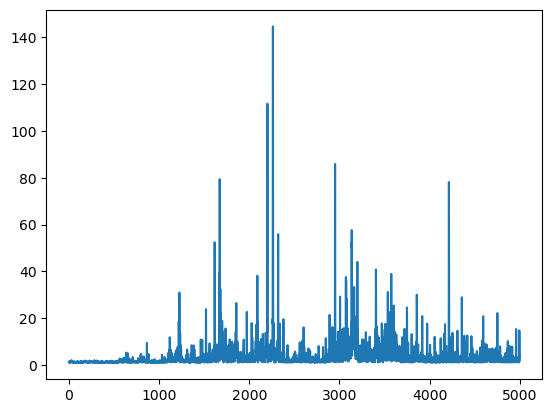

In [22]:
sns.lineplot(test_x[1])

In [23]:
train_label = y_train
test_label = y_test

In [24]:
train_x.shape, train_label.shape

(torch.Size([31200, 5000]), torch.Size([31200]))

In [25]:
test_x.shape, test_label.shape

(torch.Size([39, 5000]), torch.Size([39]))

In [26]:
dev_x.shape, dev_y.shape

(torch.Size([370, 5000]), torch.Size([370]))

In [27]:
train_dataset = TensorDataset(train_x, train_label)

In [28]:
test_dataset = TensorDataset(test_x, test_label)

In [29]:
dev_dataset = TensorDataset(dev_x, dev_y)

In [30]:
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [31]:
dataloader_test =DataLoader(test_dataset,  shuffle=True)

In [32]:
dataloader_dev = DataLoader(dev_dataset, batch_size=128, shuffle=True)

## Model Structure

In [38]:
learning_rate = 0.001
num_epochs = 10

model = nn.Sequential(    
    nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, stride=4, padding=0),  
    nn.ReLU(), 
    nn.MaxPool1d(kernel_size=2),  
    nn.BatchNorm1d(16),
    nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),  
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.BatchNorm1d(32),
    nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.BatchNorm1d(16),
    nn.Flatten(),
    nn.Linear(2464, 1240),  # Adjust according to the actual output size after the last Conv1d
    nn.ReLU(), 
    nn.Dropout(0.4), 
    nn.Linear(1240, 620),
    nn.ReLU(), 
    nn.Dropout(.4),
    nn.Linear(620, 310), 
    nn.ReLU(), 
    nn.Linear(310, 128), 
    nn.ReLU(), 
    nn.Linear(128, 64), 
    nn.ReLU(),
    nn.Linear(64, 2),
)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
print(model)

Sequential(
  (0): Conv1d(1, 16, kernel_size=(4,), stride=(4,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (5): ReLU()
  (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
  (9): ReLU()
  (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=2464, out_features=1240, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.4, inplace=False)
  (16): Linear(in_features=1240, out_features=620, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.4, inplace=False)
  (19):

### Model Training

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x_batch, labels in dataloader:
        optimizer.zero_grad()

        # Reshape x_batch to have one input channel
        x_batch = x_batch.unsqueeze(1)  # Reshape: (batch_size, 1, 5000)
        x_batch = x_batch.to(device)  # Move x_batch to device
        labels = labels.to(device)  # Move labels to device
        
        outputs = model(x_batch)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

cuda
Epoch [1/10], Loss: 0.1833
Epoch [2/10], Loss: 0.0734
Epoch [3/10], Loss: 0.0441
Epoch [4/10], Loss: 0.0393
Epoch [5/10], Loss: 0.0328
Epoch [6/10], Loss: 0.0296
Epoch [7/10], Loss: 0.0279
Epoch [8/10], Loss: 0.0274
Epoch [9/10], Loss: 0.0189
Epoch [10/10], Loss: 0.0203


## Model Evaluation

In [41]:
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

# Initialize variables to keep track of the loss and predictions
total_loss = 0.0
all_labels = []
all_predictions = []
correct_cnt = 0
neg_pred_cnt = 0 

with torch.no_grad():
    for x_batch, labels in dataloader_dev:  # Assuming you have a separate validation or test DataLoader
        # Reshape x_batch to have one input channel
        x_batch = x_batch.unsqueeze(1)  # Reshape: (batch_size, 1, 5000)
        x_batch = x_batch.to(device)  # Move x_batch to device
        
        # labels = labels.to(device)
        labels = labels.to(device).long() #DEV로 평가할 경우
        
        outputs = model(x_batch)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        
        total_loss += loss.item()  # Accumulate the loss
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_predictions.extend(predicted.cpu().numpy())  # Store predicted labels

# Calculate average loss
avg_loss = total_loss / len(dataloader)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'micro' or 'macro' if needed
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

cm = confusion_matrix(all_labels, all_predictions)

TN = cm[0, 0]  
FP = cm[0, 1] 
FN = cm[1, 0]  
TP = cm[1, 1]  

FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  

# Print results
print(f"Evaluation Loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
print(f'Predicted positives out of all negatives: {FPR} = {FP}/{FP + TN}')
print(f'Predicted negatives out of all positives: {FNR} = {FN}/{FN + TP}')
# print(all_labels)
# print(all_predictions)
for i in range(len(all_labels)) :
    if all_labels[i] == 0 and all_predictions[i] == 0:
        correct_cnt += 1
for pred in all_predictions:
    if pred == 0:
        neg_pred_cnt += 1

print(f'correct_cnt {correct_cnt}')
print(f'neg_pred_cnt {neg_pred_cnt}')
# len(all_labels)

cuda
Evaluation Loss: 0.0060
Precision: 0.8753, Recall: 0.9135, F1 Score: 0.8862
Predicted positives out of all negatives: 0.9333333333333333 = 28/30
Predicted negatives out of all positives: 0.011764705882352941 = 4/340
correct_cnt 2
neg_pred_cnt 6


## 모델 저장

In [37]:
# torch.save(model, 'model_v0.0.1.pth')